In [1]:
!pip install grad-cam

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import cv2
import random
import scipy.io
import joblib

import pandas as pd
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Function
import torch.nn.functional as F
from PIL import Image
from functions import ResNet_18

In [2]:
# load one numpy file 
image = np.load('image_5.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'image_5.npy'

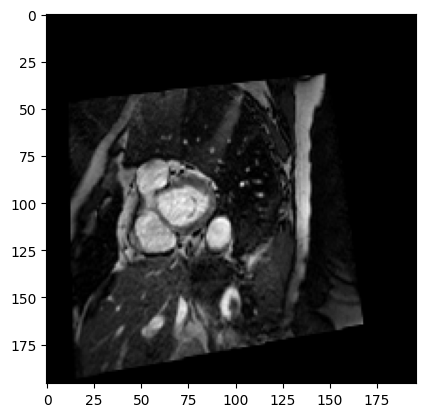

In [31]:
plt.imshow(image, cmap='gray')

In [22]:
model = ResNet_18(image_channels=1, num_classes=3, dropout_prob=0.1)
model_path = r'C:\Users\ttoxopeus\BEP\BEP_project\MRI_classification\models\best_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.cuda() if torch.cuda.is_available() else model.cpu()
model.eval()

ResNet_18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=

In [23]:
# the given image is already preprocessed but at last converted to numpy array
# so we need to convert it to torch tensor
image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()

# move the image to cuda device if available
image_tensor = image_tensor.cuda() if torch.cuda.is_available() else image_tensor.cpu()


model(image_tensor)



tensor([[-8.0583, 10.0167, -9.5982]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

In [25]:
# this line defines the corresponding label of the image, please double-check before running!
targets = [ClassifierOutputTarget(1)] # the label of image_2 is 1, 'P'ArithmeticError

# this line defines the layer we want to visualize

target_layers = [#model.layer1[-1], model.layer2[-1],
                model.layer4[-1].conv1] # the last layer of ResNet-18
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=image_tensor, targets=targets)
    #cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)


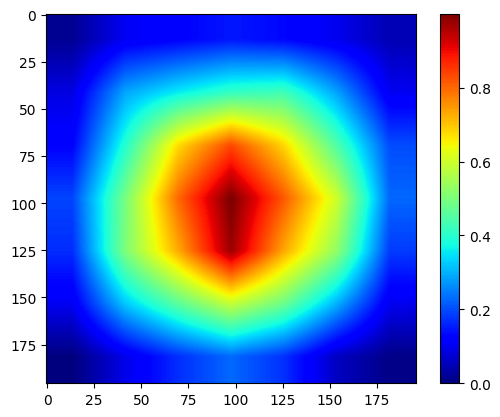

In [26]:
plt.imshow(grayscale_cams[0, :], cmap='jet')
plt.colorbar()



In [27]:
grayscale_cams.shape

(1, 196, 196)

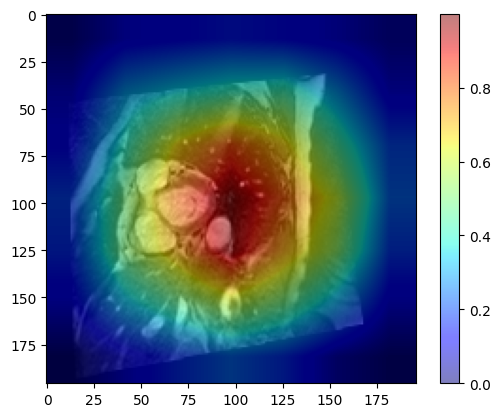

In [28]:

# then plot this cam on the original image with 0.5 transparency using matplotlib only
plt.imshow(image, cmap='gray')
plt.imshow(grayscale_cams[0, :], cmap='jet', alpha=0.5)
plt.colorbar()

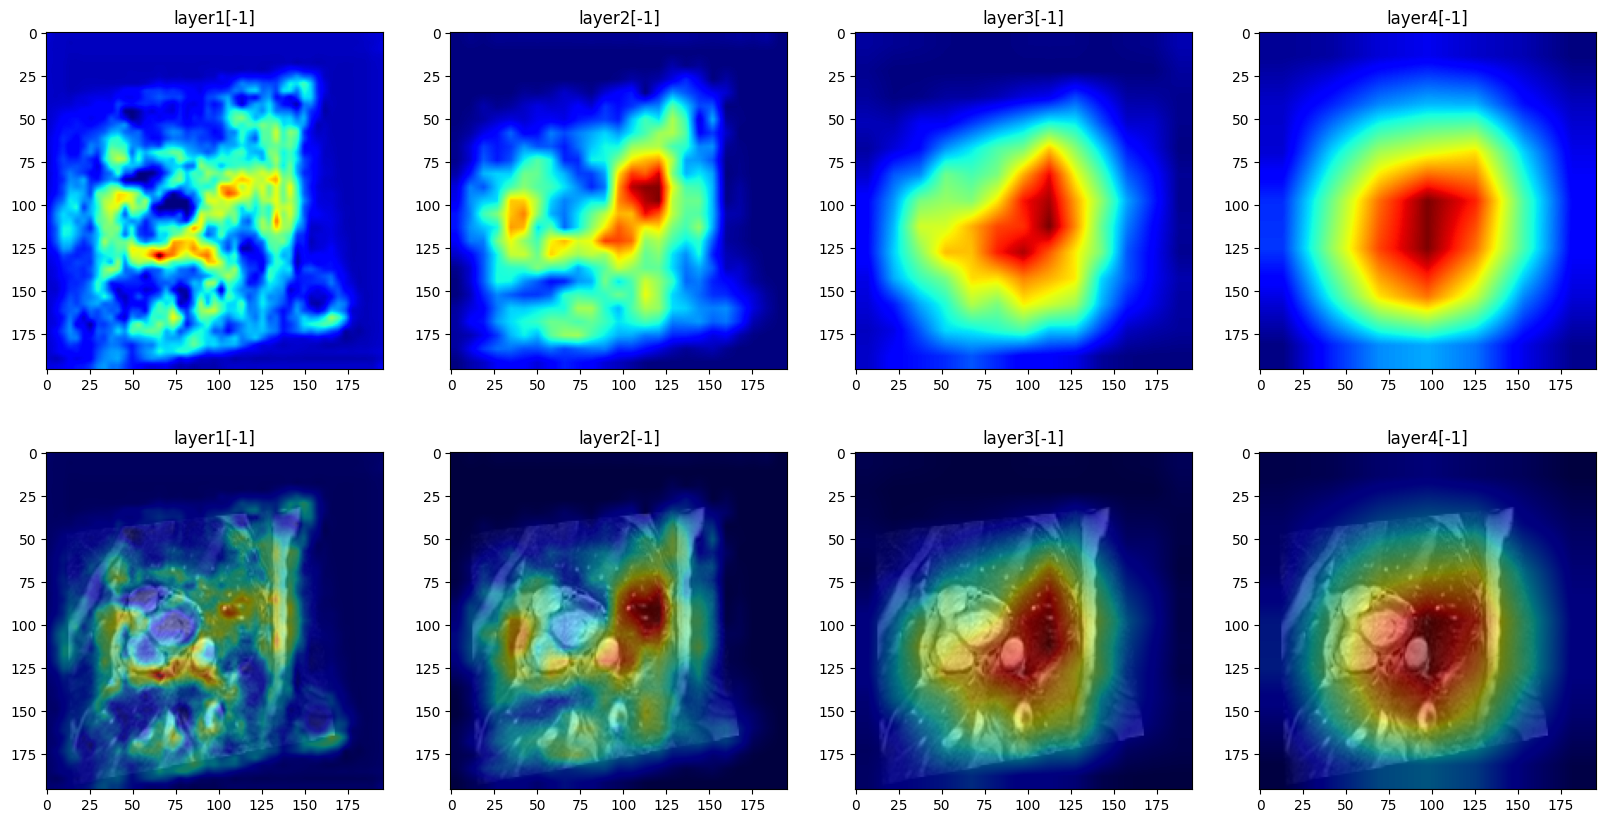

In [29]:
# TODO: now you already know how to visualize one layer (or even one block)
# to get the visualization map, now write a function to visualize all 4 layers for the correct label
# and all 4 layers for the wrong label, so you will have 8 images in total
meta_target_layers = [model.layer1[-1], model.layer2[-1],
                     model.layer3[-1], model.layer4[-1]]

target_layers_title = ['layer1[-1]', 'layer2[-1]', 'layer3[-1]', 'layer4[-1]']

# create an empty 2x4 figure
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    # note this line for the correct label!!!
    targets = [ClassifierOutputTarget(1)] # the label of image_2 is 1, 'P'ArithmeticError
    
    target_layers = [meta_target_layers[i]]# the last layer of ResNet-18
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=image_tensor, targets=targets)
        #cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
    # first row is grayscale_cams,
    # second row is the original image with the grayscale_cams overlayed
    ax[0, i].imshow(grayscale_cams[0, :], cmap='jet')

    ax[1, i].imshow(image, cmap='gray')
    ax[1, i].imshow(grayscale_cams[0, :], cmap='jet', alpha=0.5)
    # the title for each column is the layer name
    ax[0, i].set_title(target_layers_title[i])
    ax[1, i].set_title(target_layers_title[i])

    